In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

# **Visualizing Classes**

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [3]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<AxesSubplot:>

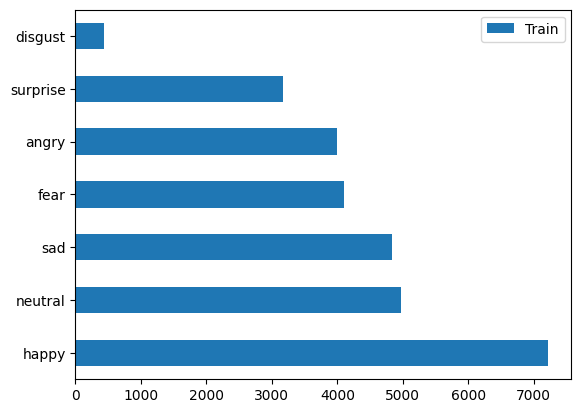

In [4]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

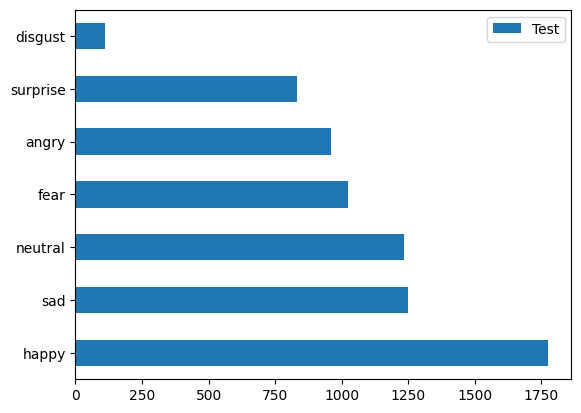

In [5]:
Test_Count.plot(kind='barh')

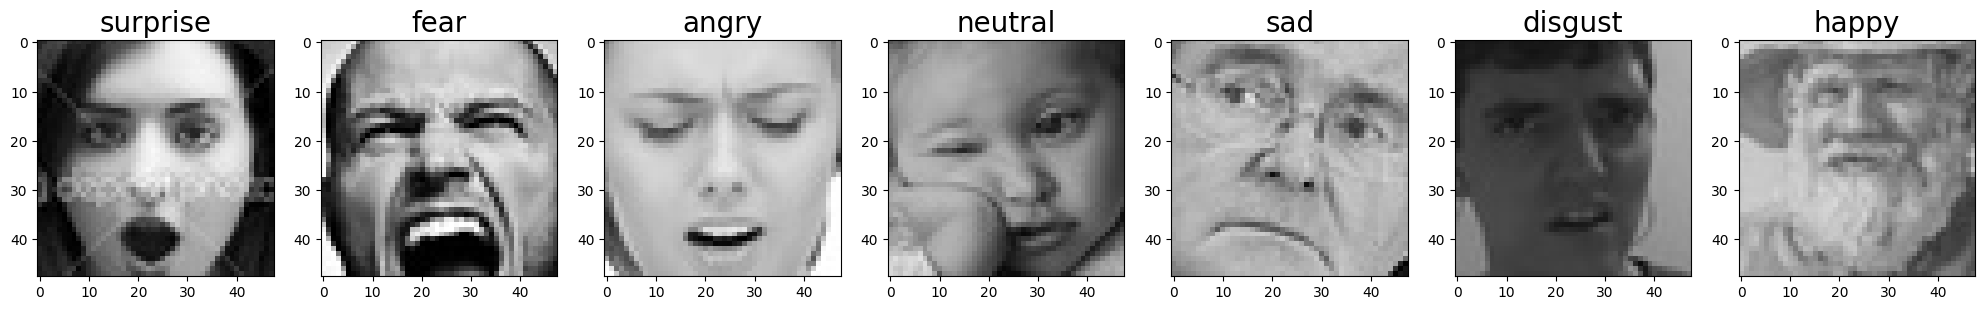

In [6]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '../input/fer2013/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [7]:
img_shape = 48
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [8]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [9]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [10]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

**Specifying Callbacks**

In [11]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [12]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 324s 704ms/step - loss: 2.0558 - accuracy: 0.2090 - val_loss: 1.8152 - val_accuracy: 0.2517
Epoch 2/50
448/448 [==============================] - 80s 177ms/step - loss: 1.7554 - accuracy: 0.2954 - val_loss: 2.0855 - val_accuracy: 0.3271
Epoch 3/50
448/448 [==============================] - 74s 165ms/step - loss: 1.6077 - accuracy: 0.3643 - val_loss: 1.4724 - val_accuracy: 0.4329
Epoch 4/50
448/448 [==============================] - 76s 170ms/step - loss: 1.4820 - accuracy: 0.4245 - val_loss: 1.3809 - val_accuracy: 0.4813
Epoch 5/50
448/448 [==============================] - 74s 165ms/step - loss: 1.4031 - accuracy: 0.4617 - val_loss: 1.4559 - val_accuracy: 0.4443
Epoch 6/50
448/448 [==============================] - 73s 163ms/step - loss: 1.3420 - accuracy: 0.4911 - val_loss: 1.3162 - val_accuracy: 0.5075
Epoch 7/50
448/448 [==============================] - 75s 168ms/step - loss: 1.3105 - accuracy: 0.5036 - val_loss: 1.3071 - val_a

# **Evaluating CNN Model**

In [13]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 10s 91ms/step - loss: 0.9337 - accuracy: 0.6539
    Test Loss: 0.93373
Test Accuracy: 65.39%


In [14]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

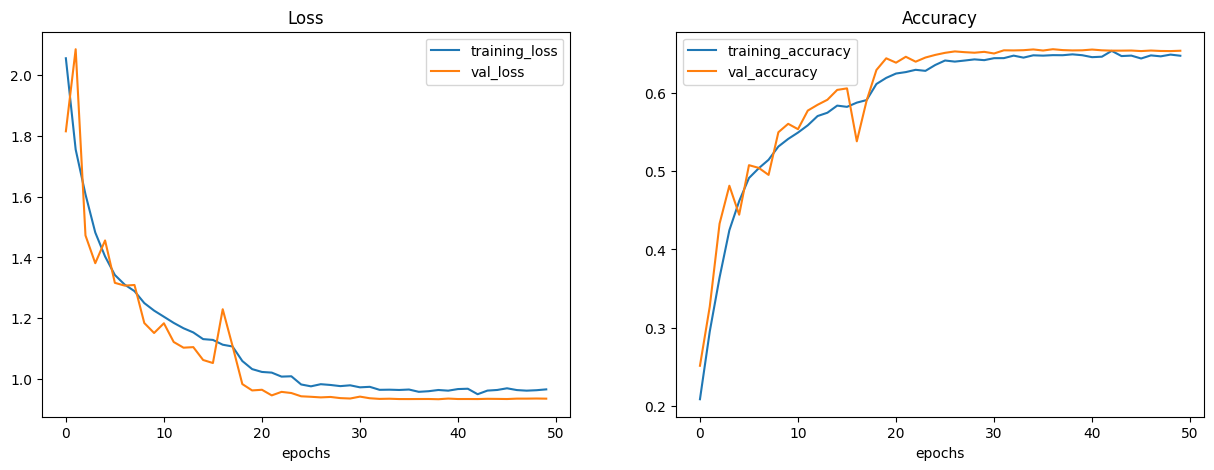

In [15]:
plot_curves(CNN_history)

In [16]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [17]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

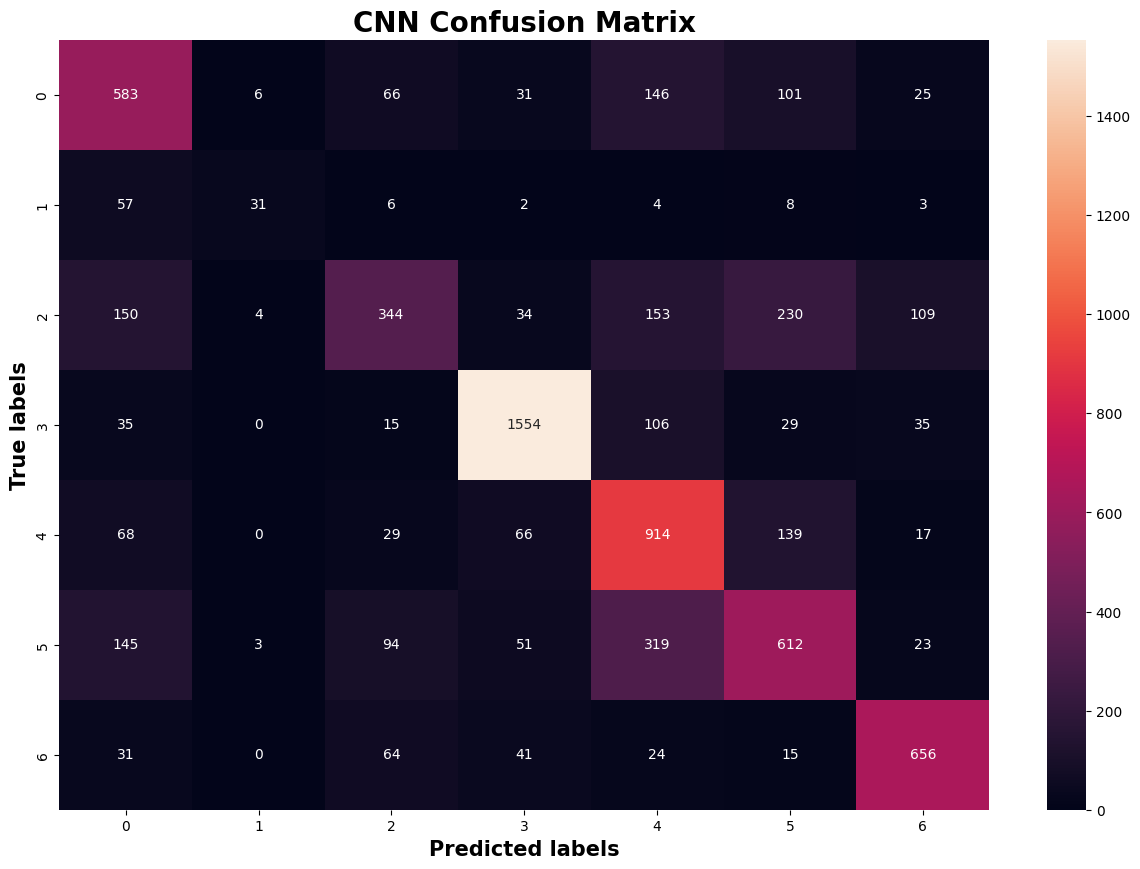

In [18]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [19]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [20]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

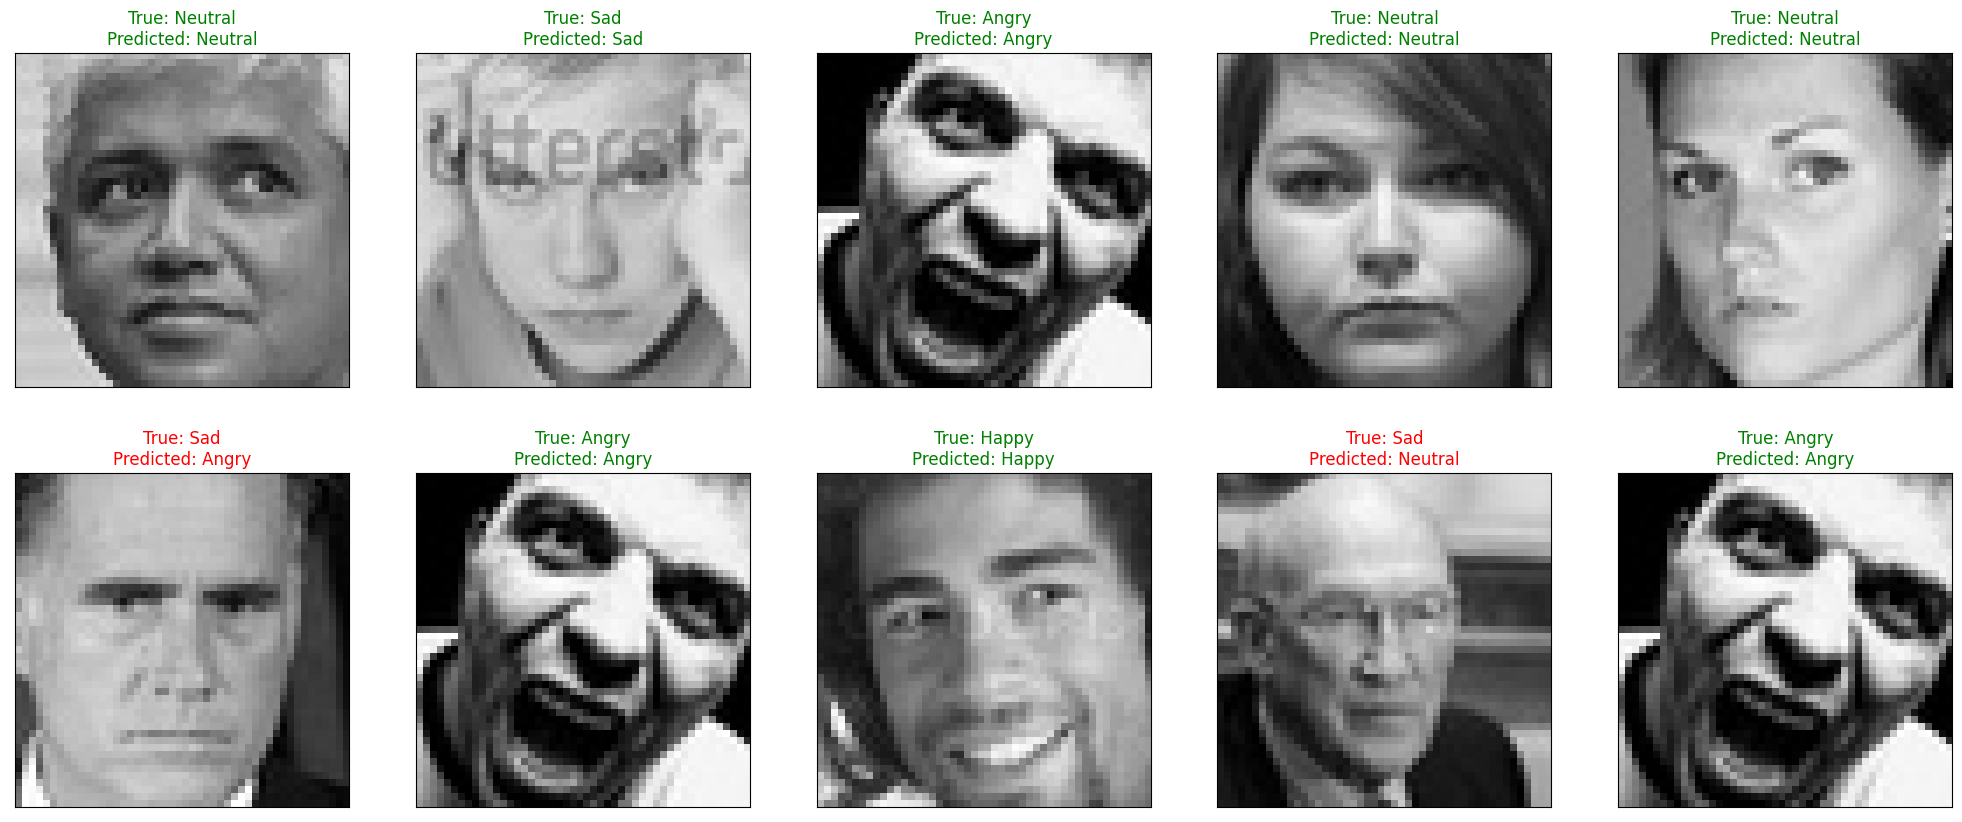

<Figure size 640x480 with 0 Axes>

In [21]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Player**

In [22]:
Music_Player = pd.read_csv("../input/spotify-music-data-to-identify-the-moods/data_moods.csv")
#Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [23]:
Music_Player["mood"].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [24]:
Music_Player["popularity"].value_counts()

0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: popularity, Length: 83, dtype: int64

In [25]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,Lost,Lost,Annelie,7nC2EOpMnpDT2DkvniimSm,2020-06-05,64,161520,0.389,0.972,0.100,0.934,0.113,0.0676,-22.464,0.0358,133.839,10,4,Calm
1,Curiosity,Curiosity,Beau Projet,3WEdWvAScE1EcBfErseQnC,2019-03-21,60,155820,0.430,0.985,0.256,0.867,0.106,0.1730,-22.088,0.0641,133.955,2,4,Calm
2,Escaping Time,Floating,Benjamin Martins,7JrSIPcfkWhDzxWII8Jz7V,2019-10-21,60,200346,0.320,0.640,0.256,0.862,0.112,0.1910,-17.980,0.0445,115.011,10,4,Calm
3,Just Look at You,432 Water Crystals,369,62X7ld1sa8RHl4zRtSvfHf,2020-02-21,59,187385,0.558,0.985,0.249,0.925,0.103,0.1110,-14.715,0.0303,94.991,7,4,Calm
4,Vague,Envision,Amaranth Cove,3IOXceWmoCrTyl5TXFDzWu,2020-01-03,59,143000,0.320,0.881,0.253,0.935,0.121,0.1250,-17.843,0.0356,140.029,10,4,Calm


In [26]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [27]:
# Tải model phát hiện mặt người
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2025-01-08 14:07:35--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.006s  

2025-01-08 14:07:36 (145 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [28]:
def load_and_prep_image(filename):
    """
    Đọc và tiền xử lý ảnh cho model CNN
    Input:
        filename: đường dẫn đến file ảnh
    Output:
        RGBImg: ảnh đã được xử lý có shape (48, 48, 3)
    """
    # Đọc ảnh
    img = cv2.imread(filename)
    if img is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn đã cho")
    
    # Chuyển ảnh sang ảnh xám
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Phát hiện khuôn mặt
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    # Nếu tìm thấy khuôn mặt, cắt và xử lý vùng khuôn mặt
    if len(faces) > 0:
        # Lấy khuôn mặt đầu tiên được phát hiện
        x, y, w, h = faces[0]
        face_img = img[y:y + h, x:x + w]
    else:
        # Nếu không tìm thấy khuôn mặt, sử dụng ảnh gốc
        face_img = img
    
    # Chuyển sang RGB và resize thành 48x48
    # (sqrt(6400) = 80, nhưng do lỗi 20736 = 144x144 nên ta thử 48x48)
    RGBImg = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (48, 48))
    
    # Đảm bảo ảnh là RGB
    if len(RGBImg.shape) == 2:
        RGBImg = cv2.cvtColor(RGBImg, cv2.COLOR_GRAY2RGB)
    
    # Chuẩn hóa ảnh
    RGBImg = RGBImg / 255.0
    
    return RGBImg

In [29]:
def pred_and_plot(filename, class_names):
    """
    Dự đoán cảm xúc từ ảnh và hiển thị kết quả
    """
    # Chuẩn bị ảnh
    img = load_and_prep_image(filename)
    
    # In ra shape của ảnh để kiểm tra
    print("Image shape before batch:", img.shape)
    
    # Thêm chiều batch
    img_batch = np.expand_dims(img, axis=0)
    print("Image shape after batch:", img_batch.shape)
    
    # Dự đoán
    pred = CNN_Model.predict(img_batch)
    
    # Lấy class được dự đoán
    pred_class = class_names[pred.argmax()]
    
    # Plot ảnh và kết quả
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis('off')
    plt.show()
    
    # In ra probabilities cho từng class
    for i, prob in enumerate(pred[0]):
        print(f"{class_names[i]}: {prob*100:.2f}%")
    Recommend_Songs(pred_class)

Image shape before batch: (48, 48, 3)
Image shape after batch: (1, 48, 48, 3)


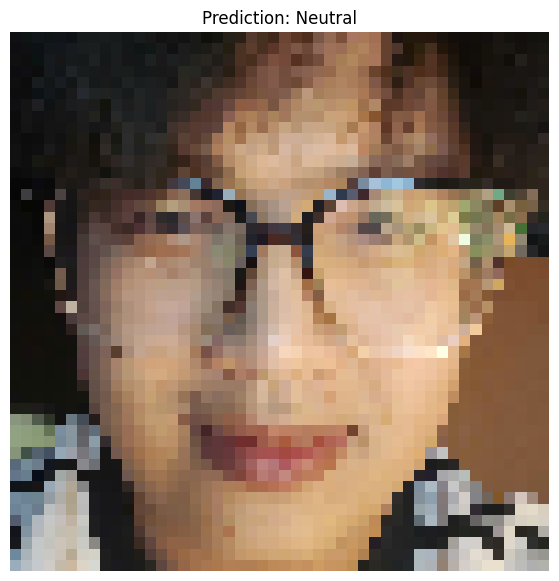

Angry: 31.40%
Disgust: 1.65%
Fear: 7.43%
Happy: 5.00%
Neutral: 40.15%
Sad: 10.29%
Surprise: 4.07%


,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,Chop Suey!,Toxicity,System Of A Down,2DlHlPMa4M17kufBvI2lEN,2001-09-04,79,210240,0.419,0.000278,0.934,0.001500,0.1320,0.286,-3.908,0.1200,127.288,7,4,Energetic
1,Killing In The Name,Rage Against The Machine - XX (20th Anniversar...,Rage Against The Machine,59WN2psjkt1tyaxjspN8fp,1992,78,313573,0.466,0.026600,0.833,0.000000,0.0327,0.661,-4.215,0.3040,88.785,7,4,Energetic
2,Dani California,Stadium Arcadium,Red Hot Chili Peppers,10Nmj3JCNoMeBQ87uw5j8k,2006-05-09,77,282160,0.556,0.019300,0.913,0.000009,0.3460,0.730,-2.360,0.0437,96.184,0,4,Energetic
3,Duality,Vol. 3: The Subliminal Verses,Slipknot,61mWefnWQOLf90gepjOCb3,2004,76,252613,0.354,0.000237,0.982,0.000294,0.2040,0.194,-3.026,0.1680,143.772,4,4,Energetic
4,Uprising,The Resistance,Muse,4VqPOruhp5EdPBeR92t6lQ,2009-09-10,75,304840,0.602,0.000202,0.905,0.064000,0.1170,0.411,-4.046,0.0775,128.019,2,4,Energetic


In [30]:
pred_and_plot("/kaggle/input/cnntest/e5fb20e6a3fa1fa446eb.jpg", Emotion_Classes) # with CNN

In [31]:
CNN_Model.save("CNN_Model.h5")